## Testing

In [1]:
import torch
from pygsig.graph import CustomStaticGraphTemporalSignal
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Create graph
num_nodes = 100
num_edges = 40
edge_index = torch.randint(0, num_nodes, (2, num_edges))
edge_weight = torch.rand(num_edges)


snapshot_count = 10
num_node_features = 5
features = [torch.randn(num_nodes, num_node_features) for _ in range(snapshot_count)]
targets = [torch.randint(0,2,(num_nodes,),dtype=torch.float) for _ in range(snapshot_count)]
pos_dim = 2
positions = torch.rand(num_nodes, pos_dim,dtype=torch.double)

dataset = CustomStaticGraphTemporalSignal(edge_index,edge_weight,features,targets,positions)


## Subduction Zone

In [2]:
# packages
import torch
import pandas as pd
from pygsig.datasets.subduction import SubductionZone
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.utils import to_networkx


In [3]:
# Download data
poly_path='datasets/subduction/polygon_large.geojson' # region of interest
data_path='datasets/subduction/site_data_large.geojson' # earthquake data
site_path='datasets/subduction/site_location_large.geojson' # site data
start_date=pd.Timestamp('2008-01-01 11:59:00+0000', tz='UTC')
end_date=pd.Timestamp('2023-12-31 11:59:00+0000', tz='UTC')
dataset = SubductionZone(poly_path=poly_path,
                         data_path=data_path,
                         site_path=site_path,
                         start_date=start_date, end_date=end_date,redownload=False)

In [4]:
# Load data
seq_data = dataset.load_data(task_name='depth',r=40e3)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,balanced_accuracy_score,confusion_matrix
from pygsig.models import GCNClassifier, MLPClassifier,ChebNetClassifier
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures
from pygsig.graph import RandomNodeSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Preprocessing
num_splits = 1
signature_transform = SignatureFeatures(seq_data.num_node_features,sig_depth=4,normalize=True)
random_split = RandomNodeSplit(num_splits=num_splits,train_ratio=0.6,eval_ratio=0.0,unlabeled_data=True)
transform = T.Compose([signature_transform,random_split])
data = transform(seq_data)

In [ ]:
scaler = StandardScaler()
data.y= torch.tensor(scaler.fit_transform(data.y.reshape(-1,1)).reshape(-1),dtype=torch.float64)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,balanced_accuracy_score,confusion_matrix
from models import GCNClassifier, MLPClassifier,ChebNetClassifier
import torch_geometric.transforms as T
from signature import SignatureFeatures
from pygsig.graph import RandomNodeSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Preprocessing
num_splits = 1
signature_transform = SignatureFeatures(seq_data.num_node_features,sig_depth=4,normalize=True)
random_split = RandomNodeSplit(num_splits=num_splits,train_ratio=0.6,eval_ratio=0.0,unlabeled_data=True)
transform = T.Compose([signature_transform,random_split])
data = transform(seq_data)

# Hyperparameters
num_trials = 10
num_epochs = 1000
learning_rate = 1e-3
weight_decay = 5e-4
prob_dropout = 0.0
num_channels = [data.num_node_features,64,32,16,num_classes]


train_losses = np.zeros([data.num_splits,num_trials,num_epochs])
test_losses = np.zeros([data.num_splits,num_trials,num_epochs])
accuracy_scores = np.zeros([data.num_splits,num_trials])
balanced_accuracy_scores = np.zeros([data.num_splits,num_trials])
precision_scores = np.zeros([data.num_splits,num_trials])
recall_scores = np.zeros([data.num_splits,num_trials])
f1_scores = np.zeros([data.num_splits,num_trials])
confusion_matrices = np.zeros([data.num_splits,num_trials,2,2])

for split in range(data.num_splits):
    for trial in range(num_trials):
        # Model
        model = GCNClassifier(num_channels,prob_dropout)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train_mask = data.train_mask[split]
        eval_mask = data.eval_mask[split]
        test_mask = data.test_mask[split]
        criteria = nn.CrossEntropyLoss()
        
        for epoch in range(1,num_epochs+1):
            # Training
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr)
            train_loss = criteria(out[train_mask], data.y[train_mask])
            train_losses[split,trial,epoch-1] = train_loss.item()
            train_loss.backward()
            optimizer.step()

            # Evaluation
            model.eval()
            with torch.no_grad():
                out = model(data.x, data.edge_index, data.edge_attr)
                test_loss = criteria(out[test_mask], data.y[test_mask])
                test_losses[split,trial,epoch-1] = test_loss.item()

            # Results
            if epoch % 100 == 0:
                # print(f'Split {split}, Trial {trial}, Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
                continue
        
        # Testing
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_attr)
            y_pred = torch.argmax(out[test_mask],dim=-1)
            y_true = data.y[test_mask]
            accuracy_scores[split,trial] = accuracy_score(y_true,y_pred)
            balanced_accuracy_scores[split,trial] = balanced_accuracy_score(y_true,y_pred)
            precision_scores[split,trial] = precision_score(y_true,y_pred,zero_division=0)
            recall_scores[split,trial] = recall_score(y_true,y_pred)
            f1_scores[split,trial] = f1_score(y_true,y_pred)
            confusion_matrices[split,trial,:,:] = confusion_matrix(y_true,y_pred)

results = (f"Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}, ",
f"Balanced Accuracy: {np.mean(balanced_accuracy_scores):.3f} ± {np.std(balanced_accuracy_scores):.3f}, ",
f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}, ",
f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}, ",
f"F1: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

print(*results)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
pos_test_nodes, neg_train_nodes = data.y[test_mask].numpy().sum(),data.y[test_mask].shape[0]-data.y[test_mask].numpy().sum()
print(f"Positive test nodes: {pos_test_nodes}, Negative test nodes: {neg_train_nodes}")
pos_train_nodes, neg_train_nodes = data.y[train_mask].numpy().sum(),data.y[train_mask].shape[0]-data.y[train_mask].numpy().sum()
print(f"Positive train nodes: {pos_train_nodes}, Negative train nodes: {neg_train_nodes}")


Positive test nodes: 7, Negative test nodes: 5
Positive train nodes: 4, Negative train nodes: 13


In [ ]:
data.y[test_mask].numpy().sum(),data.y[test_mask].shape[0]-data.y[test_mask].numpy().sum()

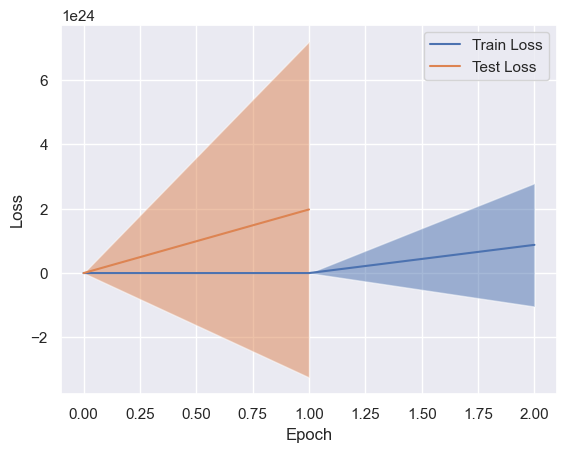

In [ ]:
sns.set_theme()
mean_train_losses = np.mean(train_losses, axis=(0, 1))
std_train_losses = np.std(train_losses, axis=(0, 1))
mean_test_losses = np.mean(test_losses, axis=(0, 1))
std_test_losses = np.std(test_losses, axis=(0, 1))

sns.lineplot(x=np.arange(num_epochs), y=mean_train_losses, label='Train Loss')
plt.fill_between(np.arange(num_epochs), mean_train_losses-std_train_losses, mean_train_losses+std_train_losses, alpha=0.5)
sns.lineplot(x=np.arange(num_epochs), y=mean_test_losses, label='Test Loss')
plt.fill_between(np.arange(num_epochs), mean_test_losses-std_test_losses, mean_test_losses+std_test_losses, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

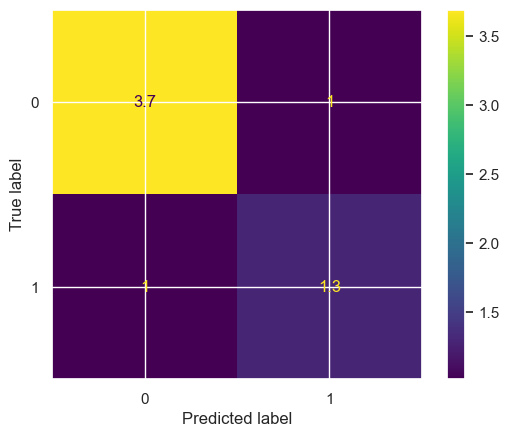

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = np.mean(np.mean(np.array(confusion_matrices),axis=0),axis=0)
cm_display = ConfusionMatrixDisplay(cm).plot()

## Signature Aggregation

In [1]:
from signature import SignatureLinear,SignatureAggregation
import torch
from torch import Tensor
from torch_geometric.nn.aggr import Aggregation,SumAggregation
from signatory import multi_signature_combine, signature_channels,extract_signature_term

In [2]:
# Example usage
input_channels = 3
depth = 2
num_arguments = 4
num_batches = 1
sig_aggr = SignatureAggregation(input_channels, depth)
sum_aggr = SumAggregation()
x = torch.randint(10,[num_arguments,signature_channels(input_channels, depth, scalar_term=False)])

In [3]:
x

tensor([[2, 0, 5, 4, 2, 2, 3, 6, 3, 4, 8, 6],
        [2, 6, 4, 5, 4, 4, 8, 5, 6, 4, 1, 3],
        [5, 8, 8, 1, 1, 2, 9, 1, 2, 6, 1, 6],
        [7, 6, 9, 0, 9, 3, 4, 6, 2, 0, 2, 8]])

In [4]:
index = torch.tensor([0,1,0,1])
sig_aggr(x)

[tensor([[2, 0, 5, 4, 2, 2, 3, 6, 3, 4, 8, 6],
        [2, 6, 4, 5, 4, 4, 8, 5, 6, 4, 1, 3],
        [5, 8, 8, 1, 1, 2, 9, 1, 2, 6, 1, 6],
        [7, 6, 9, 0, 9, 3, 4, 6, 2, 0, 2, 8]])]


ValueError: An element of sigtensors is not two-dimensional. Every element must have two dimensions, corresponding to (batch, signature_channels(input_channels, depth, scalar_term))

In [8]:
index = torch.tensor([0,0,0,1])
sum_aggr(x,index)

tensor([[ 9, 14, 17, 10,  7,  8, 20, 12, 11, 14, 10, 15],
        [ 7,  6,  9,  0,  9,  3,  4,  6,  2,  0,  2,  8]])

In [16]:
extract_signature_term(x,input_channels,1)

tensor([7, 6, 4])

In [17]:
signature_channels(input_channels, depth, scalar_term=False)

12

In [5]:
index = torch.tensor([0,1,1,0])
sum_aggr(x,index)

tensor([[ 1, 12,  8,  4, 10,  6,  3,  8,  6, 12,  1, 11],
        [11,  4,  8,  9, 14,  9, 13, 14, 10, 15, 11,  9]])

In [4]:
index = torch.tensor([0,1,1,0])
sig_aggr(x,index)

tensor([[[0, 5, 7, 2, 2, 3, 3, 1, 0, 3, 0, 9],
         [1, 7, 1, 2, 8, 3, 0, 7, 6, 9, 1, 2]],

        [[5, 4, 1, 8, 7, 6, 8, 6, 1, 6, 5, 2],
         [6, 0, 7, 1, 7, 3, 5, 8, 9, 9, 6, 7]]])

In [ ]:
from typing import Optional, List
import torch
from torch import Tensor
from torch_geometric.nn.aggr import Aggregation
from signatory import multi_signature_combine, signature_channels

class SignatureCombineAggregation(Aggregation):
    def __init__(self, input_channels: int, depth: int, inverse: bool = False, scalar_term: bool = False):
        super().__init__()
        self.input_channels = input_channels
        self.depth = depth
        self.inverse = inverse
        self.scalar_term = scalar_term

    def forward(
        self,
        x: Tensor,
        index: Optional[Tensor] = None,
        ptr: Optional[Tensor] = None,
        dim_size: Optional[int] = None,
        dim: int = -2,
        max_num_elements: Optional[int] = None
    ) -> Tensor:

        # Ensure the input tensor is of shape [N, C]
        N, _, C = x.shape
        expected_channels = signature_channels(self.input_channels, self.depth, self.scalar_term)
        if C != expected_channels:
            raise ValueError(f"Input tensor channels {C} do not match the expected signature channels {expected_channels}")

        # Create a list of tensors of size C from the input tensor
        tensors_list = [x[i] for i in range(N)]

        # Apply the signatory.multi_signature_combine function
        combined = multi_signature_combine(
            tensors_list,
            input_channels=self.input_channels,
            depth=self.depth,
            inverse=self.inverse,
            scalar_term=self.scalar_term
        )

        return combined

    def reset_parameters(self):
        pass

## PyG Temporal Datasets

In [540]:
import numpy as np
from signatory import signature,signature_channels,extract_signature_term,Augment,Signature
import torch
from torch_geometric_temporal import METRLADatasetLoader,PemsBayDatasetLoader,ChickenpoxDatasetLoader,MTMDatasetLoader
from torch_geometric_temporal import StaticGraphTemporalSignal,temporal_signal_split
import torch_geometric_temporal.nn as tgnn
import torch_geometric.nn as gnn
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data

In [601]:
num_frames = 32
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=1)

In [603]:
t = np.random.choice(dataset.snapshot_count)
dataset[t].x.shape

torch.Size([20, 1])

In [ ]:
count = 0
for snapshot in dataset:
    if torch.all(torch.argmax(snapshot.y,dim=1)==torch.argmax(snapshot.y[-1])):
        count+=1


In [515]:
dataset[1].x[0]

tensor([ 2.8571e-02,  3.5474e-01,  2.9544e-01,  7.1057e-01, -6.8308e-01,
         2.9544e-01, -2.0865e-01,  2.1339e+00, -1.4244e+00, -8.9064e-01,
         1.3926e+00, -1.1575e+00,  7.4022e-01, -6.5342e-01,  1.7187e+00,
        -1.1575e+00,  6.5126e-01, -5.0516e-01,  1.1553e+00,  5.9196e-01,
        -4.7551e-01, -1.0389e+00, -1.0814e-03,  1.7484e+00, -3.4111e+00,
         8.5883e-01, -1.6616e+00, -1.1969e-01,  4.1405e-01, -4.4586e-01,
        -1.4934e-01, -3.0733e-02])

In [487]:
def to_static_graph_dataset(dataset: StaticGraphTemporalSignal) -> Data:
    num_nodes = dataset[0].num_nodes
    num_node_features = dataset[0].num_node_features
    seq_length = dataset.snapshot_count
    if len(dataset[0].y.shape)>1:
        num_node_targets = dataset[0].y.shape[-1]
    else:
        num_node_targets = 1
    x = torch.zeros([num_nodes,seq_length,num_node_features])
    y = torch.zeros([num_nodes,seq_length,num_node_targets])
    for time,snapshot in enumerate(dataset):
        x[:,time,:] = snapshot.x
        if len(snapshot.y.shape)>1:
            y[:,time,:] = snapshot.y
        else:
            y[:,time,:] = snapshot.y.unsqueeze(-1)
    dataset_static = Data(x=x,y=y,edge_index=dataset.edge_index,edge_attr=dataset.edge_weight)
    return dataset_static

In [493]:
static_train = to_static_graph_dataset(train_dataset)
static_test = to_static_graph_dataset(test_dataset)

In [593]:
static_data = to_static_graph_dataset(dataset)

RuntimeError: expand(torch.FloatTensor{[3, 21, 32]}, size=[3, 32]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [478]:
dataset_static

Data(x=[20, 520, 1], edge_index=[2, 102], edge_attr=[102], y=[20, 520, 1])

In [474]:
y.shape

torch.Size([20, 520, 1])

In [469]:
dataset[0]

Data(x=[20, 1], edge_index=[2, 102], edge_attr=[102], y=[20])

In [492]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [453]:
augmented = Augment(in_channels=dataset[0].num_node_features,include_time=True,layer_sizes=(2),kernel_size=1,include_original=True)
signature = Signature(depth=3)

path_in = torch.zeros([dataset[0].num_nodes,dataset.snapshot_count,dataset[0].num_node_features])
path_out = torch.zeros([dataset[0].num_nodes,dataset.snapshot_count,1])

for time,snapshot in enumerate(dataset):
    path_in[:,time,:] = snapshot.x
    path_out[:,time,:] = snapshot.y.unsqueeze(dim=-1)

path_in = augmented(path_in)

input_signature = signature(path_in)
output_signature = signature(path_out)

dataset_sig = Data(x=input_signature,y=output_signature,edge_index=train_dataset.edge_index)
dataset_sig.edge_index = torch.tensor(dataset_sig.edge_index,dtype=torch.long)

In [457]:
path_out[0,:,:]

tensor([[ 0.0286,  0.0000,  0.0297,  0.0517],
        [ 0.3547,  0.0019, -0.2131, -0.0753],
        [ 0.2954,  0.0039, -0.1689, -0.0522],
        ...,
        [-0.4755,  0.9961,  0.4048,  0.2479],
        [-0.2086,  0.9981,  0.2062,  0.1440],
        [ 1.2146,  1.0000, -0.8530, -0.4100]], grad_fn=<SliceBackward0>)

In [456]:
path_in[0,:,:]

tensor([[-0.0011,  0.0000,  0.0517,  0.0632],
        [ 0.0286,  0.0019,  0.0297,  0.0517],
        [ 0.3547,  0.0039, -0.2131, -0.0753],
        ...,
        [-0.2976,  0.9961,  0.2724,  0.1787],
        [-0.4755,  0.9981,  0.4048,  0.2479],
        [-0.2086,  1.0000,  0.2062,  0.1440]], grad_fn=<SliceBackward0>)

In [432]:
dataset[2].y

tensor([ 0.2954,  1.0922, -1.5487,  1.1862, -0.6375, -0.1627,  1.7434,  0.6700,
         1.8545, -0.0830, -0.0723, -0.2477, -0.1637,  0.3495, -0.1286,  0.1902,
        -0.9437,  1.1855,  1.5630,  1.2647])

In [421]:
class RegressionGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels,out_channels):
        super(RegressionGNN, self).__init__()
        self.conv1 = gnn.GCNConv(in_channels, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index,edge_weight=None):
        x = F.relu(self.conv1(x, edge_index,edge_weight))
        x = self.conv2(x, edge_index,edge_weight)
        return x.flatten()

In [462]:
import torch as torch
import torch_geometric.nn as gnn
import torch.nn.functional as F

In [464]:
dataset[0].x.shape

torch.Size([20, 1])

In [ ]:
class SignatureGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels,out_channels, sig_depth):
        super(SignatureGNN, self).__init__()
        self.signature = Signature(depth=sig_depth)
        self.augment = Augment(in_channels=in_channels,include_time=True,layer_sizes=(),kernel_size=1,include_original=True)
        self.conv1 = gnn.GCNConv(in_channels, hidden_channels)
    def forward(self, x, edge_index,edge_weight=None):
        x = self.augment(x)
        x = self.signature(x)
        x = F.relu(self.conv1(x, edge_index,edge_weight))
        return x.flatten()
        

In [427]:
train_dataset_sig 

Data(x=[20, 3], edge_index=[2, 102], y=[20])

In [458]:
# hyperparameters
num_epochs = 10000
learning_rate = 1e-5
hidden_channels = [64,32]

model = RegressionGNN(in_channels=train_dataset_sig.num_node_features, hidden_channels=hidden_channels, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_dataset_sig.x, train_dataset_sig.edge_index)
    loss = criterion(out, train_dataset_sig.y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        out = model(test_dataset_sig.x, test_dataset_sig.edge_index)
        test_loss = criterion(out, test_dataset_sig.y)
    if epoch % 100 == 99:
        print(f'Epoch: {epoch+1}/{num_epochs}, Train loss: {loss.item()}, Test loss: {test_loss.item()}')
        

TypeError: empty() received an invalid combination of arguments - got (list, int), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


## Flocking

In [47]:
import yaml

In [54]:
config_path = '../datasets/flock/config.yaml'
with open(config_path, 'r') as file:
    data = yaml.safe_load(file)

In [56]:
data

{'num_trials': 10,
 'x_min': 0,
 'x_max': 100,
 'y_min': 0,
 'y_max': 100,
 'max_velocity': 5.0,
 'radius': 10.0,
 'dist_safe': 5.0,
 'sigma': 10.0,
 'damp_x': 0.99,
 'damp_y': 0.99,
 'num_iterations': 400,
 'dt': 0.1,
 'num_targets': 8,
 'target_seed': 0,
 'num_agents': 48,
 'min_num_leaders': 3,
 'max_num_leaders': 6,
 'separation_weight': 5.0,
 'alignment_weight': 1.0,
 'cohesion_weight': 0.5,
 'leader_weight': 1.0}

## Traffic

In [1]:
import pandas as pd
data_path = '../datasets/traffic/metr-la.h5'
from pandas import HDFStore

In [2]:
store = HDFStore(data_path)
df = store['df']
store.close()

Want to label each time period by 

In [9]:
df.index[0]

Timestamp('2012-03-01 00:00:00')

In [11]:
from datetime import datetime, time
from pandas import Timestamp

# Example timestamp
timestamp = Timestamp('2012-03-01 00:00:00')

# Define time range
start_time = time(0, 0)
end_time = time(3, 0) 

start_time <= timestamp.time() < end_time

True

In [18]:
df.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125,67.125,59.625000,62.750000,...,45.625000,65.500,64.500000,66.428571,66.875,59.375000,69.000000,59.250000,69.000000,61.875
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000,65.000,57.444444,63.333333,...,50.666667,69.875,66.666667,58.555556,62.000,61.111111,64.444444,55.888889,68.444444,62.875
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500,64.250,63.875000,65.375000,...,44.125000,69.000,56.500000,59.250000,68.125,62.500000,65.625000,61.375000,69.857143,62.000
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000
